Jupyter notebook by Adriana Dropulic and Zeineb Mezghanni
# StreamGen: Getting Started
Welcome to `StreamGen` v1! In this tutorial, we load a merger tree from `SatGen`, a semi-analytic model of subhalo evolution within a host halo, and use `StreamGen` identify which satellites remain intact, which form shells, and which evolve into streams. 

### Prerequisites:
- Ensure that both SatGen and StreamGen are installed and in the same directory.
- If the directories differ, adjust the paths accordingly in the `StreamGen` python scripts.

### References:
For more detailed information, please refer to the following papers (link them accordingly):
- [SatGen Paper](https://academic.oup.com/mnras/article/502/1/621/6066532?login=false)
- [StreamGen Paper]

First, we'll load the `load_galaxy` module to create a Galaxy object:
This object will hold all the properties of the `SatGen` galaxy, allowing us to analyze its attributes. 

Note: In `SatGen`, you will likely have to modify the path to the `etc` folder in `config.py`, since we are not working in the `SatGen` directory. Please add the lines to `config.py`:

```python 
import os
etc_path = os.path.abspath(os.path.join(__file__, "./../../SatGen/"))+"/"
```

And add `etc_path+` to the beginning of the call to the files in the `etc` folder.
###### (for example, change ``gvdb_mm = np.load('etc/gvdb_mm.npy')`` to ``gvdb_mm = np.load(etc_path + 'etc/gvdb_mm.npy')``)

In [2]:
import load_galaxy

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


Next, we create a Galaxy object from the `SatGen` merger tree. 

In [3]:
path_to_SatGen_tree = './'
SatGen_tree_name = 'tree677_lgM11.61'
galaxy = load_galaxy.Galaxy(datadir= path_to_SatGen_tree, tree_file = SatGen_tree_name, disk_fraction = 0.05, flattening=25., stellar_mass_floor=5e5)

path to galaxy .//tree677_lgM11.61.npz
flattening 25.0
disk fraction 0.05
stellar_mass_floor 500000.0


Note that all the attributes of the Galaxy object are defined in the `load_galaxy.py` file. The following block of code defines the attributes needed for either `StreamGen` or for subsequent analysis. 

A few definitions:

- `num_satellites`: Total number of satellites being modeled.
- `num_surviving_satellites`: Number of satellites that survive (based on stellar mass and other criteria).
- `num_snapshots`: Number of snapshots in the simulation (i.e., different times/redshifts).

In [4]:
#print("Attributes of the Galaxy object:", list(vars(galaxy).keys()))

In [5]:
# Attributes are all defined in load_galaxy.py
mapped_attributes = [
    'mass_lost_alls',  # List of mass lost fractions for each satellite; shape: (num_satellites,)
    'rps',  # List of radial distances at pericenters for each satellite; shape: (num_satellites,)
    'rh_halfs',  # List of half-mass radii for each satellite; shape: (num_satellites,)
    'mass_ratios',  # List of final stellar mass to halo virial mass ratios for each satellite; shape: (num_satellites,)
    'rho_bars',  # List of mean densities within the half-mass radius for each satellite; shape: (num_satellites,)
    'ras',  # List of radial distances at apocenters for each satellite; shape: (num_satellites,)
    'eccs',  # List of orbital eccentricities for each satellite; shape: (num_satellites,)
    'sat_final_mstar',  # Final stellar masses of surviving satellites; shape: (num_surviving_satellites,)
    'sat_final_mvir',  # Final virial masses of surviving satellites; shape: (num_surviving_satellites,)
    'sat_final_rvir',  # Final virial radii of surviving satellites; shape: (num_surviving_satellites,)
    'stellar_mass_lost_alls',  # List of stellar mass lost fractions for each satellite; shape: (num_satellites,)
    'CosmicTime',  # Cosmic time at each snapshot in the simulation; shape: (num_snapshots,)
    'allz_mstar_s',  # Stellar masses of surviving satellites at all redshifts; shape: (num_surviving_satellites, num_snapshots)
    'allz_m_s',  # Total masses (stellar + dark matter) of surviving satellites at all redshifts; shape: (num_surviving_satellites, num_snapshots)
    'sat_distances',  # List of distances for all satellites at all times; shape: (num_satellites, num_snapshots)
    'pericenter_locs',  # Indices of pericenter locations for each satellite; shape: (num_satellites,)
    'apocenter_locs',  # Indices of apocenter locations for each satellite; shape: (num_satellites,)
    'coordinates_apo',  # Cylindrical coordinates of satellites at apocenters; shape: (num_satellites, 3)
    'coordinates_peri',  # Cylindrical coordinates of satellites at pericenters; shape: (num_satellites, 3)
    'velocities_apo',  # Velocities of satellites at apocenters; shape: (num_satellites, 3)
    'all_apo',  # Values of apocenter distances for each satellite; shape: (num_satellites,)
    'all_peri',  # Values of pericenter distances for each satellite; shape: (num_satellites,)
    'num_sat_s',  # Indices of surviving satellites; shape: (num_surviving_satellites,)
    'z',  # Redshift at each snapshot in the simulation; shape: (num_snapshots,)
    'x',  # X-coordinates of surviving satellites at all times; shape: (num_surviving_satellites, num_snapshots)
    'y',  # Y-coordinates of surviving satellites at all times; shape: (num_surviving_satellites, num_snapshots)
    'idx_zaccs',  # Indices of accretion for each satellite; shape: (num_satellites,)
    'coordinates_hold',  # Stored (cylindrical) coordinates of satellites over time; shape: (num_satellites, num_snapshots, 3)
    'velocity_dispersion',  # Velocity dispersion of satellites at z=0; shape: (num_satellites,)
    'velocities_hold',  # Stored velocities of satellites over time; shape: (num_satellites, num_snapshots, 3)
    's001s',  # Specific quantity "s001" at z=0 for each satellite (possibly a model-specific parameter); shape: (num_satellites,)
    'velocities_peri',  # Velocities of satellites at pericenters; shape: (num_satellites, 3)
    'redshift'  # Redshift values; shape: (num_snapshots,)
]


Next, we create a dataframe (`substructure_df`) that holds the properties of the surviving satellites in the galaxy that `StreamGen` will need. In this version, the surviving satellites are within the host at z = 0 and have pericenter > 4 kpc. 

In [6]:
substructure_df = galaxy.get_filtered_rows_as_dataframe(mapped_attributes)

The heart of StreamGen consists of the code that performs the morphology metric assignment. 
`substructure_z0` contains the code that governs the substrucure assignment. 
Two notes: 
1. By default, in this version of `StreamGen`, the morphology assignment will occur at z=0. 
2. This code is setup to multiprocess when integrating sampled satellite particles and should use whatever resources you give it. 
You can of course change the multiprocessing configuration to suit your configuration. 

In [7]:
import substructure_z0

num_samples = 20 #!change to ~300 when using mpi on cluster to get accurate derivative quantites!
subs = substructure_z0.Substructure(substructure_df, 'trial', galaxy, num_samples)
start_idx = 0 #first satellite to process
stop_idx = len(subs.df) #last satellite to process
subs.classify_substructure(start_idx, stop_idx) 

Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files
Directory already exists: ./../../StreamGen/trial/
Loaded MC files


In [8]:
print("Attributes of the subs object:", list(vars(subs).keys())) #defined in substructure_z0.py

Attributes of the subs object: ['df', 'tag', 'galaxy', 'num_samples', 'id_sat_stream', 'lookback', 'peri_all_reintegrate', 'apo_all_reintegrate', 'PL_over_PE_arr', 'PE_list', 'PL_list', 'host_profiles', 'Norb_list', 'sats_per_gal', 'mass_lost']


Now, to visualize the results: 

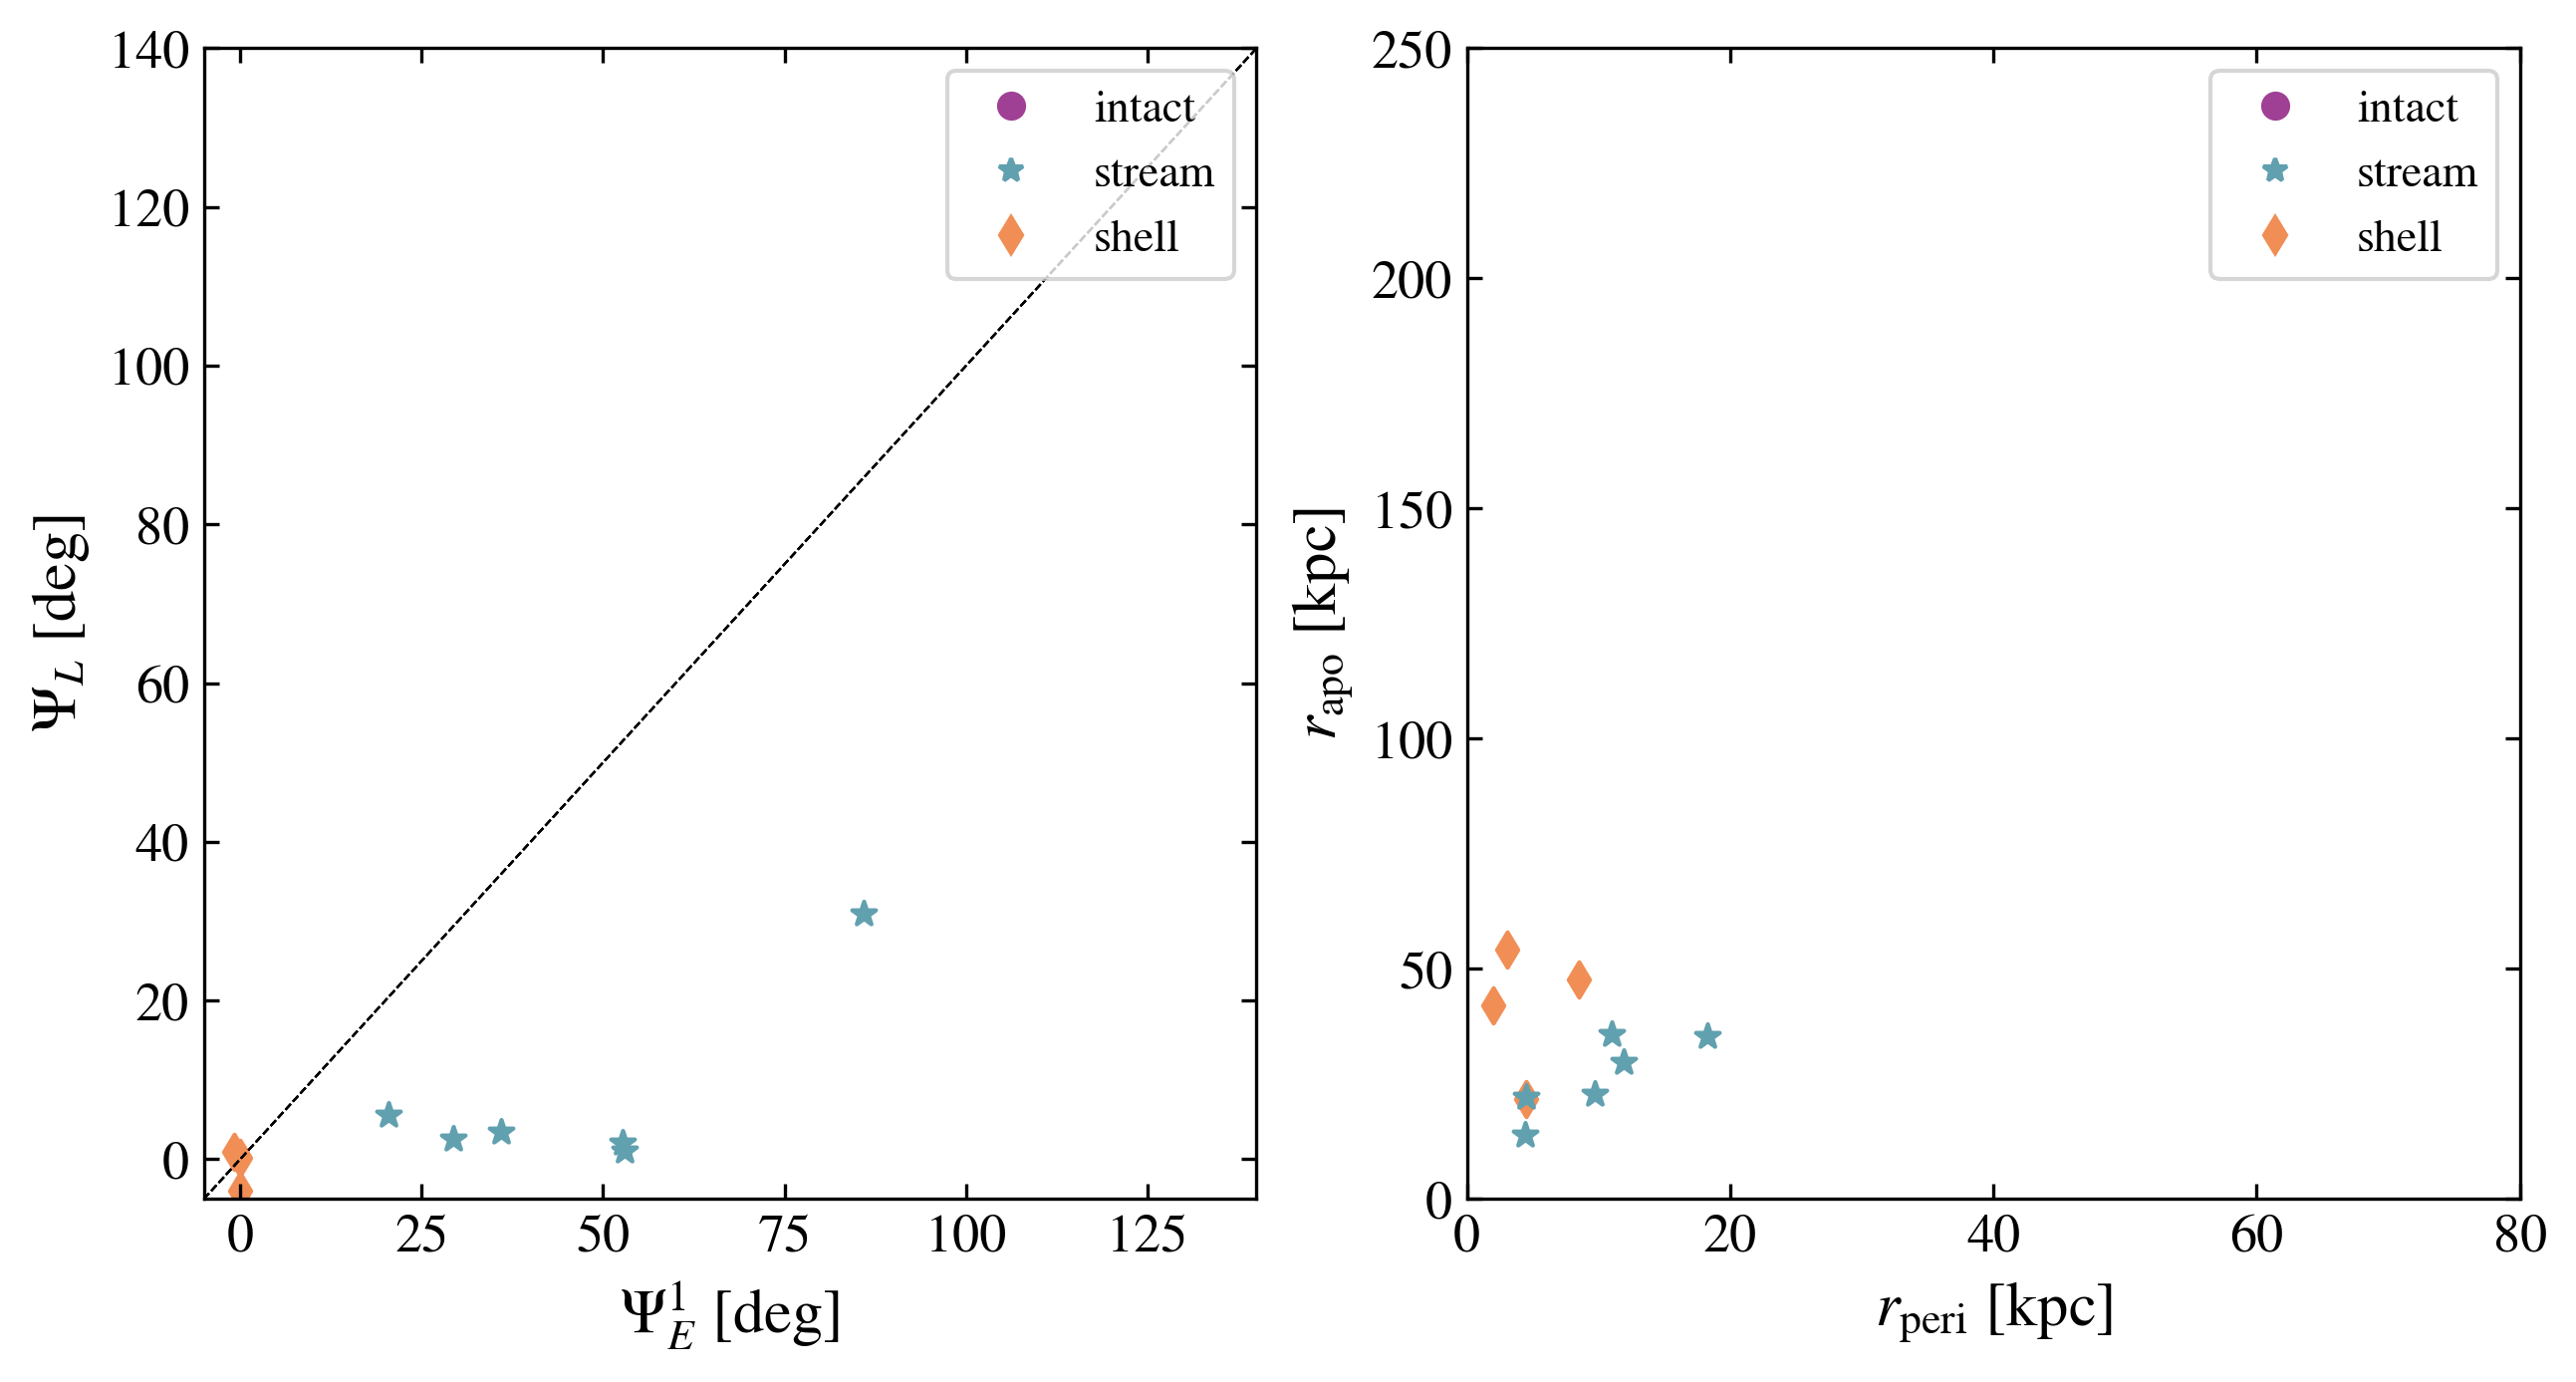

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.lines import Line2D 

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.dpi'] = 300
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
matplotlib.rcParams.update({
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    })
blue  = '#61A0AF'
purple = '#A04095'
orange = '#F18E55'
fig, ax= plt.subplots(nrows = 1, ncols = 2, sharex=False , sharey=False,figsize=(10,5))
# Loop over satellites in the galaxy
for sub_i in range(len(subs.id_sat_stream)):
    # If the satellite is intact 
    if subs.id_sat_stream[sub_i] == 0:
        marker = 'o'
        color = purple
    # If the satellite is a stream 
    elif subs.id_sat_stream[sub_i] == 1:
        marker = '*'
        color = blue
    # If the satellite is a shell
    elif subs.id_sat_stream[sub_i] == 2:
        marker = 'd'
        color = orange
    # Scatter plot the stream angle vs. the shell angle for all satellites
    ax[0].scatter(np.rad2deg(subs.PE_list[sub_i]), np.rad2deg(subs.PL_list[sub_i]), marker = marker, color = color)
    low_psiEL = -5
    high_psiEL = 140
    ax[0].plot( [low_psiEL,high_psiEL],[low_psiEL,high_psiEL] , color = 'black', linestyle = 'dashed', linewidth = 0.5, alpha = 0.5)
    ax[0].set_xlim([low_psiEL,high_psiEL])
    ax[0].set_ylim([low_psiEL,high_psiEL])
    ax[0].set_xlabel(r'$\Psi^1_E$ [deg]')
    ax[0].set_ylabel(r'$\Psi_L$ [deg]')
      
    # Scatter plot the pericenter and apocenter for all satellites
    ax[1].scatter(subs.peri_all_reintegrate[sub_i], subs.apo_all_reintegrate[sub_i], marker = marker, color = color)
    ax[1].set_ylim([0,250])#200
    ax[1].set_xlim([0,80])#50
    ax[1].set_xlabel(r'$r_{\mathrm{peri}}$ [kpc]')
    ax[1].set_ylabel(r'$r_{\mathrm{apo}}$ [kpc]')
    
custom_lines = [Line2D([], [], color=purple, marker = 'o', linestyle = 'None'),
                Line2D([], [], color=blue, marker = '*', linestyle = 'None'),
                Line2D([], [], color=orange, marker = 'd', linestyle = 'None')]
legend = ax[0].legend(custom_lines, ['intact','stream','shell'], ncol = 1,  loc = 'upper right',prop={'size': 11})
legend = ax[1].legend(custom_lines, ['intact','stream','shell'], ncol = 1,  loc = 'upper right',prop={'size': 11})

